In [1]:
import pandas as pd
import datasets
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn.parallel import DataParallel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
train_data = pd.read_csv('./described_dataset_label.csv',sep='\t',encoding='latin-1')
print(f'coumns:{[x for x in train_data.columns]}')

coumns:['FILE', 'AUTHOR', 'TECHNIQUE', 'URL']


In [3]:
import requests
from bs4 import BeautifulSoup,Comment
import numpy as np

def get_description(url):    
    r = requests.get(url)
    html_content = r.text

    soup = BeautifulSoup(html_content,'html.parser')

    comment = soup.find(string=lambda text: isinstance(text,Comment))
    if not comment:
        return 0
    
    parent_element = comment.find_parent()
    p_tag=parent_element.find('p')
    text_content = ''.join(p_tag.stripped_strings)
    return text_content

In [4]:
features = ['FILE','AUTHOR','TECHNIQUE','URL']
train_data = train_data[features]
train_data = train_data[:1000]
train_data['TECHNIQUE'] = train_data['TECHNIQUE'].str.split(',').str[0]
train_data['TECHNIQUE'] = train_data['TECHNIQUE'].str.split(':').str[0]
train_data.head()

,FILE,AUTHOR,TECHNIQUE,URL
0,./images/1.jpg,"AACHEN, Hans von",Oil on copper,"The painting, displaying the characteristic Ma..."
1,./images/2.jpg,"AACHEN, Hans von",Oil on canvas,The representation of this group is related to...
2,./images/3.jpg,"AACHEN, Hans von",Copperplate,At the end of the 16th century the court of Em...
3,./images/4.jpg,"AACHEN, Hans von",Oil on canvas,Rudolf II (1552-1612) was the son of the Holy ...
4,./images/5.jpg,"AACHEN, Hans von",Oil on canvas,Hans von Aachen was an artist who fully embrac...


In [5]:
train_data.dropna()
train_data = train_data[train_data['URL'] != 0]

In [6]:
train_data = train_data.rename(columns={'FILE':'image','AUTHOR':'author', 'TECHNIQUE':'style','URL':'description'})

In [7]:
labels_auth = train_data['author'].unique()
label2id_auth, id2label_auth = dict(), dict()
for i, label in enumerate(labels_auth):
    label2id_auth[label]=i
    id2label_auth[i]=label

In [8]:
labels_sty = train_data['style'].unique()
label2id_sty, id2label_sty = dict(), dict()
for i, label in enumerate(labels_sty):
    label2id_sty[label]=i
    id2label_sty[i]=label

In [9]:
train_data['author'] = train_data['author'].map(label2id_auth)
train_data['style'] = train_data['style'].map(label2id_sty)
train_data.columns

Index(['image', 'author', 'style', 'description'], dtype='object')

In [10]:
train_dataset = datasets.Dataset.from_pandas(train_data).cast_column('image',datasets.Image())
train_dataset_git = datasets.Dataset.from_pandas(train_data[['image','description']]).cast_column('image',datasets.Image())
train_dataset_vit_auth = datasets.Dataset.from_pandas(train_data[['image','author']]).cast_column('image',datasets.Image())
train_dataset_vit_style = datasets.Dataset.from_pandas(train_data[['image','style']]).cast_column('image',datasets.Image())
print(train_dataset)

Dataset({
    features: ['image', 'author', 'style', 'description'],
    num_rows: 1000
})


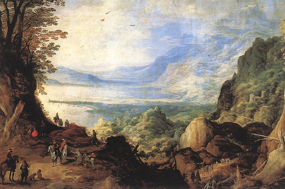

Description: Allori's Titus Quinctius Flamininus's Speech before the Achaeans is located on the long wall containing Andrea del Sarto's Triumph of Caesar. Allori placed the event in a large columned hall that opens up onto a landscape.Titus Quinctius Flamininus (c. 229 BC-c. 174 BC) was a Roman politician and general instrumental in the Roman conquest of Greece. This historical scene shows us Titus Quinctius Flamininus, the victor at Cynoscephalae at a meeting with the Achaeans in Aigon in 192 BC, where he so convinced the Achaeans with his speech that they decided to consider the enemies of Rome as their own enemies as well and declare war against them. This is an analogy to Lorenzo de' Medici's appearance at the Congress of Cremona in February 1483, where he once again demonstrated his powers of persuasion on the stated fighting Venice in the Ferrarese War (1482â84).
Author: 54
Technique: 21


In [11]:
sample = train_dataset[289]

image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
caption = sample['description']
author = sample['author']
technique = sample['style']
print(f'Description: {caption}')
print(f'Author: {author}')
print(f'Technique: {technique}')

In [12]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["description"], padding="max_length", return_tensors="pt", truncation=True)
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [13]:
from transformers import AutoModelForImageClassification

checkpoint = './model_checkpoints/model_auth'
model_clas_auth = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels = len(labels_auth),
    id2label = id2label_auth,
    label2id = label2id_auth,
    ignore_mismatched_sizes=True
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at ./model_checkpoints/model_auth and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([109, 768]) in the checkpoint and torch.Size([115, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([109]) in the checkpoint and torch.Size([115]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import AutoModelForImageClassification

checkpoint = './model_checkpoints/model_sty'
model_clas_sty = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels = len(labels_auth),
    id2label = id2label_auth,
    label2id = label2id_auth,
    ignore_mismatched_sizes=True
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at ./model_checkpoints/model_sty and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([98, 768]) in the checkpoint and torch.Size([115, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([98]) in the checkpoint and torch.Size([115]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import AutoImageProcessor

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

checkpoint= 'google/vit-base-patch16-224-in21k'
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

inputs = image_processor(image, return_tensors="pt").to(device)

with torch.no_grad():
    logits_auth = model_clas_auth(**inputs).logits

In [16]:
from transformers import AutoImageProcessor

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

inputs = image_processor(image, return_tensors="pt").to(device)

with torch.no_grad():
    logits_sty = model_clas_sty(**inputs).logits

In [17]:
from transformers import AutoProcessor
processor_capt = AutoProcessor.from_pretrained("microsoft/git-base")

In [18]:
from transformers import AutoModelForCausalLM

model_capt = AutoModelForCausalLM.from_pretrained('./model_checkpoints/model_capt').to(device)

In [19]:
inputs = processor_capt(images = image, return_tensors='pt').to(device)
pixel_values = inputs.pixel_values

generated_ids = model_capt.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor_capt.batch_decode(generated_ids,skip_special_tokens=True)[0]
print(generated_caption)

the picture shows the central panel of the polyptych of the apocalypse. in the centre of the polyptych is god the father in glory with the lamb, between the symbols of the four evangelists. the ineffably expressive natural


In [20]:
predicted_label_auth = logits_auth.argmax(-1).item()
predicted_label_sty = logits_sty.argmax(-1).item()
print(model_clas_auth.config.id2label[predicted_label_auth])
print(model_clas_sty.config.id2label[predicted_label_sty])

ABILDGAARD, Nicolai
ANGELO DI NALDUCCIO


In [21]:
predicted_label_auth = model_clas_auth.config.id2label[predicted_label_auth]
predicted_label_sty = model_clas_sty.config.id2label[predicted_label_sty]
text=predicted_label_auth+' '+predicted_label_sty + ' ' + generated_caption

In [22]:
import torch
from transformers import LlamaModel, LlamaTokenizer

def generate_text(strings, model_name='Llama-2-7b', max_length=100, temperature=1.0, top_k=50):
    # Load pre-trained GPT-2 model and tokenizer
    tokenizer = LlamaTokenizer.from_pretrained(model_name)
    # Add a new padding token to the tokenizer
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    model = LlamaModel.from_pretrained(model_name)

    # Set the model to evaluation mode (no training)
    model.eval()

    # Tokenize the input strings and convert them to tensors
    inputs = tokenizer(strings, return_tensors='pt', padding=True, truncation=True)

    # Generate text based on the input strings
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=max_length,
            temperature=temperature,
            top_k=top_k,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode the generated tokens back to text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

generate_text(text)

OSError: Llama-2-7b is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

# Project Work

In [29]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

# if using torch < 2.0
# pipe.enable_xformers_memory_efficient_attention()

prompt = generated_caption + " Using the style " + predicted_label_sty
images = pipe(prompt=prompt).images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

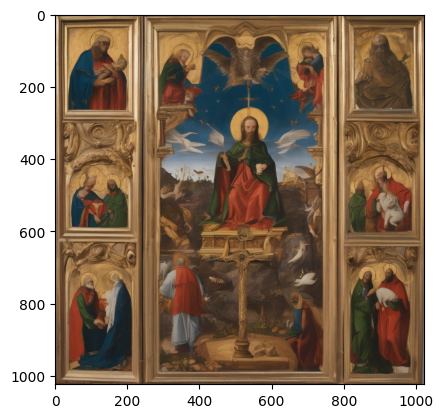

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(images)
plt.show()